In [1]:
# import library
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

import pymoo
from pymoo.model.problem import Problem

import pandas as pd


import joblib

In [2]:
# import ML model

ML_model_Llt = joblib.load('leakage_inductance_0609.pkl')
ML_model_Lmt = joblib.load('magnetizing_inductance_0609.pkl')
ML_model_Rt = joblib.load('Rt_0609.pkl')
ML_model_Rr = joblib.load('Rr_0609.pkl')

In [21]:

# core loss parameter
core_temp = 70

core_a = 0.6942
core_x = 1.4472
core_y = 2.4769
core_b = 4.7948
core_c = 0.0684
core_d = 4e-4
core_LT = core_b - core_c*core_temp + core_d*core_temp**2



# NSAG-II main

popsize = int(100/5)
offsprings = int(3000/5)

N11 = np.concatenate((8*np.ones(offsprings),9*np.ones(offsprings),10*np.ones(offsprings),11*np.ones(offsprings),12*np.ones(offsprings)), axis=None)
N12 = np.concatenate((8*np.ones(popsize),9*np.ones(popsize),10*np.ones(popsize),11*np.ones(popsize),12*np.ones(popsize)), axis=None)

freq = 30e+3

permeability = 3500

b_N1 = [4,12]
b_w1 = [30,200]
b_l1 = [10,50]
b_l2 = [50,110]
b_h1 = [50,200]
b_space1 = [20,50]
b_space2 = [20,50]
b_space3 = [5,50]
b_space4 = [5,50]
b_coil_width1 = [3,10]
b_coil_width2 = [3,10]
b_move_z1 = [1,5]
b_move_z2 = [1,5]
b_offset_z1 = [-20,20]
b_offset_z2 = [-20,20]


class MyProblem(Problem):
    def __init__(self, ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr):
        super().__init__(n_var=15,     #number of inputs
                         n_obj=2,     #number of outputs
                         n_constr=40,  #nubmer of constraints
                         xl=np.array([b_N1[0],b_w1[0],b_l1[0],b_l2[0],b_h1[0],b_space1[0],b_space2[0],b_space3[0],b_space4[0],
                         b_coil_width1[0],b_coil_width2[0],b_move_z1[0],b_move_z2[0],b_offset_z1[0],b_offset_z2[0]]), #input lower bounds
                         xu=np.array([b_N1[1],b_w1[1],b_l1[1],b_l2[1],b_h1[1],b_space1[1],b_space2[1],b_space3[1],b_space4[1],
                         b_coil_width1[1],b_coil_width2[1],b_move_z1[1],b_move_z2[1],b_offset_z1[1],b_offset_z2[1]])) #input upper bounds
        self.ML_model_Llt = ML_model_Llt
        self.ML_model_Lmt = ML_model_Lmt
        self.ML_model_Rt = ML_model_Rt
        self.ML_model_Rr = ML_model_Rr




# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
    def _evaluate(self, X, out, *args, **kwargs):

        
        # metric dimension
        #try :
        #    X[:,0] = N11
        #    #temp = X[:,0]*X[:,1]
        #except :
        #    X[:,0] = N12

        N1 = X[:,0] 

        w1 = X[:,1] * 1e-3
        l1 = X[:,2] * 1e-3
        l2 = X[:,3] * 1e-3
        h1 = X[:,4] * 1e-3

        space1 = X[:,5] * 1e-3 # 1차 측 w 방향
        space2 = X[:,6] * 1e-3 # 1차 측 l 방향
        space3 = X[:,7] * 1e-3 # 2차 측 w 방향
        space4 = X[:,8] * 1e-3 # 2차 측 l 방향

        coil_width1 = X[:,9] * 1e-3
        coil_width2 = X[:,10] * 1e-3

        move_z1 = X[:,11] * 1e-3
        move_z2 = X[:,12] * 1e-3

        offset_z1 = X[:,13] * 1e-3
        offset_z2 = X[:,14] * 1e-3


        V1 = 1036
        I1 = 100
        I2 = 100

        l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
        l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
        h = 2*l1 + h1
        wp = 1*w1 + 2*space1 + coil_width1
        ws = 1*w1 + 2*space3 + coil_width2

        hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
        hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)

        
        # Lmt
        f1 = self.ML_model_Lmt.predict( X ) # [unit : mH]
        Lmt = f1 * 1e-6 * permeability/1000 # [unit : H]

        # total volume
        f2 = l * h * wp   # Volume [Unit : m^3]
        f3 = l * h * ws   # Volume [Unit : m^3]

        V = f2

        A = l * wp
        
        V_core = (2*l1+l2)*h*w1 - l2*h*w1 # Core volume [unit : m^3]

        mag_current = V1/(2*3.141592*freq)/Lmt
        Req = N1**2/Lmt
        flux = N1 * mag_current/Req
        B = flux / (2*w1*l1)
        #B = V1 / (2*l1*w1) / (2*3.141592*freq) / N1

        coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]
        f4 = coreloss

        f5 = self.ML_model_Rt.predict( X ) * I1**2 # copperloss_tx [unit : W]
        f6 = self.ML_model_Rr.predict( X ) * I2**2 # copperloss_rx [unit : W]

        f7 = f4+f5*1+f6*3 # total loss [unit : W]

        f8 = self.ML_model_Llt.predict( X ) # [unit : uH]
        Llt = f8 * 1e-6 # [unit : H]
        #print(np.average(Llt[0]*1e+6))



        #gLlt1 = -(Llt * 1.5 - 16.77e-6) * (Llt * 0.5 - 16.77e-6) / 5e-12 * 10 # Llt constraint
        #gLlt2 = -(Llt * 1.05 - 16.77e-6) * (Llt * 0.95 - 16.77e-6) / 5e-12 * 1 # Llt constraint
        gLlt = -(Llt * 1.02 - 32.375e-6 * 1) * (Llt * 0.98 - 32.375e-6 * 1) / 5e-12 * 10 # Llt constraint
        gLmt = -(Lmt - 500e-6) * (Lmt - 10e-3) * 500e-12
        #print(np.average(gLlt))

        gspace1 = - (space1 - coil_width1 - 20e-3) * (space1 - 50e-3) / 10e-6 # 1차측 w방향
        gspace2 = - (space2 - coil_width2 - 20e-3) * (space2 - 50e-3) / 10e-6 # 1차측 l방향
        gspace3 = - (space3 - coil_width1 - 5e-3) * (space3 - 50e-3) / 10e-6 # 2차측 w방향
        gspace4 = - (space4 - coil_width2 - 5e-3) * (space4 - 50e-3) / 10e-6 # 2차측 l방향
        gspace = -(space1-space3)*(space1-40e-3)/10e-6

        gl = -(l-0e-3)*(l-250e-3) / 250e-6
        gl2 = -(l2-l_inner-50e-3)*(l2-500e-3) / 400e-3

        gh = -(h-0e-3)*(h-140e-3) / 160e-6
        ghp = -(h1-hp-10e-3) * (h1 - 400e-3) / 400e-3
        ghs = -(h1-hs-10e-3) * (h1 - 400e-3) / 400e-3


        gwp = -(wp-0e-3)*(wp-180e-3) / 250e-6
        gws = -(ws-0e-3)*(ws-180e-3) / 250e-6

        

        gB = -(B-0)*(B-0.3) / 0.3 / 0.3

        gV = -(f2-f3) / 1e-3
        print(np.average(B))

        
        """
        g1 = g_N1
        g2 = gLlt3
        g1 = gspace1
        g2 = gspace2
        g3 = gspace3
        g4 = gspace4
        g5 = gh11
        g6 = gh12
        g7 = gl
        g8 = gh
        g9 = gw
        g10 = gB
        g11= g_ins1
        g12 = g_ins2
        g13 = g_ins3
        g14 = g_ins4
        g15 = g_air1
        g16 = g_air2
        g17 = g_air3
        g18 = g_air4
        """

        #g_space = [g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18]
        #g_space = [g1.T,g2.T,g3.T,g4.T,g5.T,g6.T,g7.T,g8.T,g9.T,g10.T,g11.T,g12.T,g13.T,g14.T,g15.T,g16.T,g17.T,g18.T]
        #g_space = np.swapaxes(g_space,0,1)
        #g_space = np.where(g_space<0 , 0 , g_space)
        #vec = np.vectorize(math.clamp(X,0))

        #print(g_space[0])


        out["F"] = np.column_stack([V, f7]) # "Minimize" values (volume, coreloss)
        out["G"] = np.column_stack([gLlt, gLmt, gspace1, gspace2, gspace3, gspace4, gspace, gl, gl2, gh, ghp, ghs, gwp, gws, gB, gV])
        
        out["G"] = - out["G"] # Actually < 0 

problem = MyProblem(ML_model_Llt, ML_model_Lmt, ML_model_Rt, ML_model_Rr)


In [22]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

# ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","freq","Llt","Llr"]
mask = ["int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int", "int"]

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=3000,

    sampling = MixedVariableSampling(mask, {
        "int": get_sampling("int_random")
    }),

    crossover = MixedVariableCrossover(mask, {
        "int": get_crossover("int_sbx", prob=0.7, eta=10)
    }),

    #mutation=get_mutation("real_pm", eta=40),
    mutation = MixedVariableMutation(mask, {
        "int": get_mutation("int_pm", eta=1)
    }),

    eliminate_duplicates=True
)

In [23]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 1000)

In [24]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=15, #RANDOM SEED
               save_history=False,
               verbose=True)
res

#print("Best solution found: %s" % res.X)
#print("Function value: %s" % res.F)
#print("Constraint violation: %s" % res.CV)

0.2023757451657309
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  4.44759E+01 |  6.72866E+02 |       1 |            - |            -
0.15143053167078127
    2 |    3100 |  5.029055642 |  3.75694E+01 |       1 |  2.17355E+02 |        ideal
0.1416503427438773
    3 |    6100 |  0.102305000 |  4.305237856 |       1 |  3.45598E+02 |        ideal
0.1637952340176307
    4 |    9100 |  0.031700000 |  0.352595277 |       1 |  4.97952E+01 |        ideal
0.159869571377747
    5 |   12100 |  0.030120000 |  0.109342576 |       1 |  1.037773336 |        ideal
0.15186206428642543
    6 |   15100 |  0.018232500 |  0.038198825 |       1 |  1.64543E+02 |        ideal
0.15094687350124847
    7 |   18100 |  0.00000E+00 |  0.019819375 |       1 |  8.00788E+01 |        ideal
0.16824112517726988
    8 |   21100 |  0.00000E+00 |  0.002986645 |       1 |  5.040147472 |        ideal
0.2163290358768428
    9 |   24100 |  0.00000E+00 |  0.00000E+00 |     

188.5855351859215

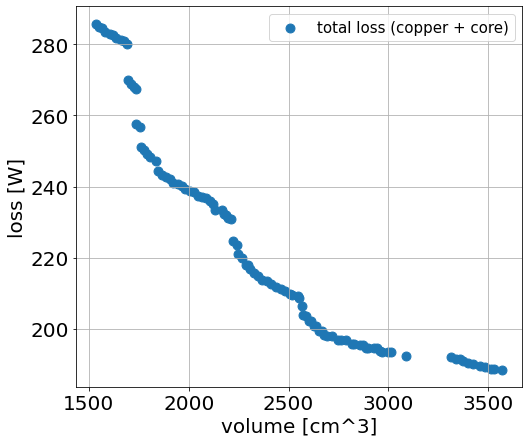

In [ ]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(res.F[:,0]*1e+6, res.F[:,1] ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)"], fontsize=15)

min(res.F[:,1])

In [ ]:
res.F[1,0]*1e+6

1535.7600000000002

In [ ]:
res.X[1]

array([10, 51, 18, 88, 54, 27, 23, 27, 8, 3, 3, 1, 1, 0, 0], dtype=object)

In [ ]:
res.X[1]

array([10, 51, 18, 88, 54, 27, 23, 27, 8, 3, 3, 1, 1, 0, 0], dtype=object)

In [ ]:
N1 = res.X[:,0] 

w1 = res.X[:,1] * 1e-3
l1 = res.X[:,2] * 1e-3
l2 = res.X[:,3] * 1e-3
h1 = res.X[:,4] * 1e-3

space1 = res.X[:,5] * 1e-3
space2 = res.X[:,6] * 1e-3
space3 = res.X[:,7] * 1e-3
space4 = res.X[:,8] * 1e-3

coil_width1 = res.X[:,9] * 1e-3
coil_width2 = res.X[:,10] * 1e-3

move_z1 = res.X[:,11] * 1e-3
move_z2 = res.X[:,12] * 1e-3

offset_z1 = res.X[:,13] * 1e-3
offset_z2 = res.X[:,14] * 1e-3

V1 = 1036
I1 = 100
I2 = 100

l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
h = 2*l1 + h1
wp = 1*w1 + 2*space1 + coil_width1
ws = 1*w1 + 2*space3 + coil_width2

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)


X_column = ["N1","w1","l1","l2","h1","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(res.X, columns=X_column)
X_data = X_data.astype(float)
#X_data = pd.to_numeric(X_data)


Lmt = ML_model_Lmt.predict( X_data ) * 1e-3 * permeability / 1000

V = l * h * wp

V_core = (2*l1+l2)*h*w1 - l2*h*w1

mag_current = V1/(2*3.141592*freq)/Lmt
Req = N1**2/Lmt
flux = N1 * mag_current/Req
B = flux / (2*w1*l1)

coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]

copperloss_tx = ML_model_Rt.predict( X_data ) * I1**2
copperloss_rx = ML_model_Rr.predict( X_data ) * I2**2

total_loss = coreloss + copperloss_tx + copperloss_rx
copperloss = copperloss_tx + copperloss_rx

Llt = ML_model_Llt.predict( X_data )

In [ ]:
np.transpose(np.concatenate([[V*1e+6],[copperloss_tx],[copperloss_rx]],axis=0)).shape

(100, 3)

In [ ]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

pd.concat([X_data,pd.DataFrame(np.transpose(np.concatenate([[V*1e+6],[Lmt],[Llt],[total_loss],[copperloss_tx],[copperloss_rx],[copperloss],[coreloss]],axis=0)),columns=["V","Lmt","Llt","total_loss","copperloss_tx","copperloss_rx","copperloss","coreloss"])], axis=1)

,N1,w1,l1,l2,h1,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,V,Lmt,Llt,total_loss,copperloss_tx,copperloss_rx,copperloss,coreloss
0,10.0,72.0,22.0,107.0,95.0,28.0,25.0,28.0,12.0,5.0,5.0,2.0,3.0,1.0,0.0,3567.991,1.267369,31.92376,188.585535,90.894969,74.026394,164.921363,23.664172
1,10.0,51.0,18.0,88.0,54.0,27.0,23.0,27.0,8.0,3.0,3.0,1.0,1.0,0.0,0.0,1535.76,1.164919,31.797265,285.831764,126.536122,125.001883,251.538005,34.293759
2,10.0,42.0,32.0,107.0,76.0,28.0,26.0,28.0,12.0,5.0,5.0,1.0,1.0,0.0,0.0,3085.88,1.141932,31.74523,192.478061,86.562662,75.535236,162.097898,30.380163
3,10.0,71.0,20.0,104.0,95.0,28.0,25.0,28.0,12.0,5.0,5.0,2.0,3.0,1.0,0.0,3314.52,1.276325,31.878902,192.026137,90.894969,74.121824,165.016792,27.009345
4,10.0,52.0,20.0,91.0,54.0,27.0,23.0,27.0,8.0,3.0,3.0,1.0,1.0,0.0,0.0,1690.59,1.163284,32.211093,280.044913,125.992126,124.263078,250.255204,29.789708
5,10.0,53.0,18.0,84.0,64.0,27.0,23.0,27.0,8.0,3.0,3.0,1.0,2.0,-3.0,0.0,1694.0,1.386262,32.056366,269.8638,130.041632,103.82238,233.864012,35.999788
6,10.0,53.0,18.0,87.0,64.0,27.0,24.0,27.0,8.0,3.0,3.0,2.0,2.0,0.0,0.0,1738.0,1.370344,31.859391,257.697007,118.527514,103.169705,221.697219,35.999788
7,10.0,55.0,18.0,85.0,64.0,27.0,23.0,27.0,8.0,3.0,3.0,1.0,2.0,-3.0,0.0,1736.0,1.381816,32.394755,267.31477,129.788734,103.442761,233.231495,34.083275
8,10.0,54.0,18.0,87.0,64.0,27.0,24.0,27.0,8.0,3.0,3.0,2.0,2.0,0.0,0.0,1753.8,1.370344,31.859391,256.716775,118.527514,103.169705,221.697219,35.019556
9,10.0,42.0,28.0,96.0,64.0,27.0,23.0,27.0,8.0,3.0,3.0,2.0,2.0,0.0,0.0,2209.68,1.358059,31.898114,230.944455,107.80695,91.420541,199.227491,31.716964


188.5855351859215

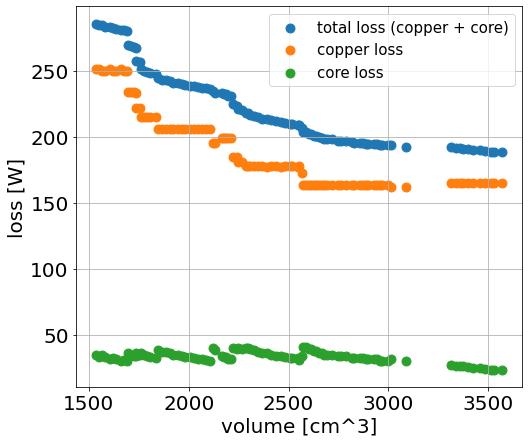

In [ ]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, total_loss ,s=80)
plt.scatter(V*1e+6, copperloss ,s=80)
plt.scatter(V*1e+6, coreloss ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("loss [W]", fontsize=20)
plt.grid(True)
plt.legend(["total loss (copper + core)","copper loss","core loss"], fontsize=15)

min(res.F[:,1])

188.5855351859215

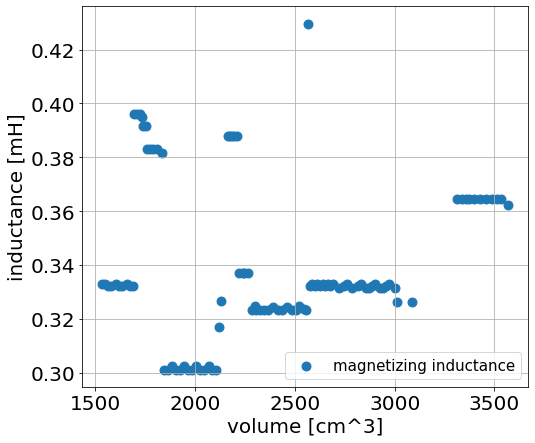

In [ ]:
plt.rcParams["figure.figsize"] = (8,7)

parameters = {'xtick.labelsize' : 20,
          'ytick.labelsize' : 20}
plt.rcParams.update(parameters)

plt.scatter(V*1e+6, Lmt ,s=80)
plt.xlabel("volume [cm^3]", fontsize=20)
plt.ylabel("inductance [mH]", fontsize=20)
plt.grid(True)
plt.legend(["magnetizing inductance"], fontsize=15)

min(res.F[:,1])